# Import library

In [13]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import xml.etree.cElementTree as ET

In [14]:
# Path of the dataset
path ='F:\\downloads'

In [15]:
import os
print('Past working directory:' ,os.getcwd())
os.chdir(path)# Path of the dataset
path ='F:\\downloads'
print('Updated working directory:',os.getcwd())

Past working directory: F:\downloads
Updated working directory: F:\downloads


In [16]:
# Read band 2 of Landsat-8 for Dehradun region
band2 = gdal.Open('LC08_L1TP_146039_20220911_20220911_02_RT_B2.TIF')

In [17]:
band2

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001A495476720> >

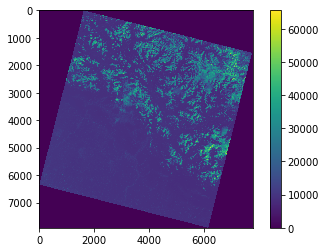

In [18]:
# Read the band as array for manipulation
band2Arr = band2.ReadAsArray().astype('float')
plt.imshow(band2Arr)
plt.colorbar()

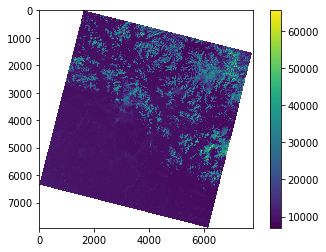

In [19]:
# Mask the border values (zeros) to NaN
band2Arr[band2Arr==0] = np.nan
plt.imshow(band2Arr)
plt.colorbar()

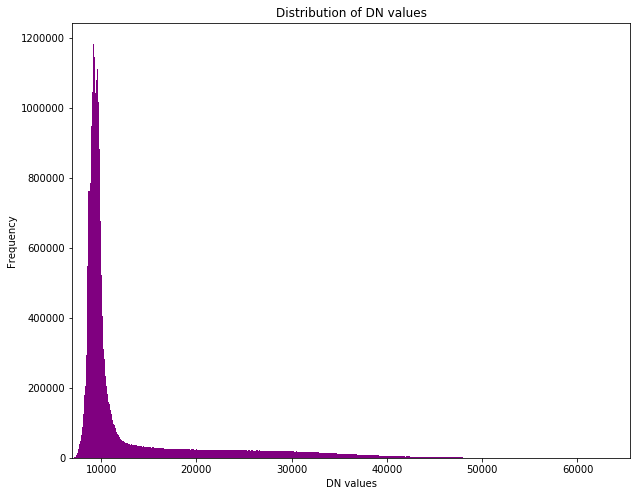

In [20]:
xmin = np.nanmin(band2Arr)
xmax = np.nanmax(band2Arr)
fig, ax = plt.subplots(figsize =(10,8))
plt.hist(x= band2Arr.flatten(), color ='purple',bins=1000)
ax.set(title="Distribution of DN values",
       xlabel = "DN values",
       ylabel ="Frequency",
      xlim = (xmin,xmax)
      )
plt.show()

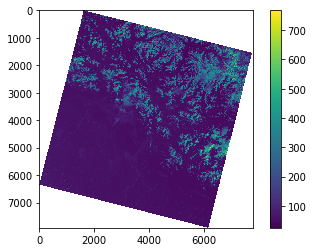

In [22]:
# Calibrate DN to radiance
RADIANCE_MULT_BAND_2 = 1.2685E-02
RADIANCE_ADD_BAND_2 = -63.42311
ML = RADIANCE_MULT_BAND_2
AL = RADIANCE_ADD_BAND_2
Spectral_radiance_band_2 = ML*band2Arr + AL
plt.imshow(Spectral_radiance_band_2)
plt.colorbar()

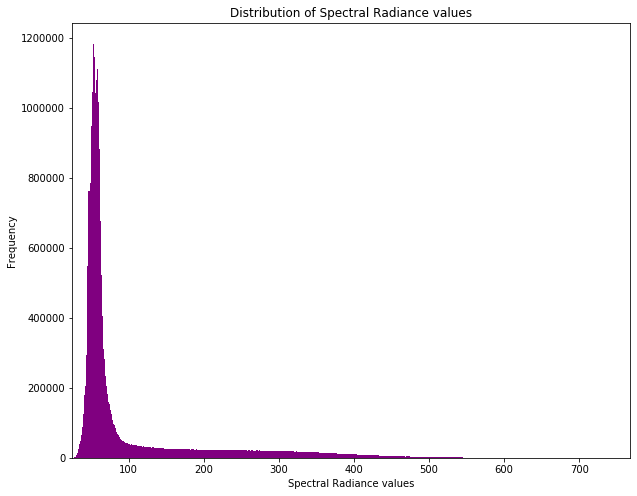

In [23]:
xmin = np.nanmin(Spectral_radiance_band_2)
xmax = np.nanmax(Spectral_radiance_band_2)
fig, ax = plt.subplots(figsize =(10,8))
plt.hist(x= Spectral_radiance_band_2.flatten(), color ='purple',bins=1000)
ax.set(title="Distribution of Spectral Radiance values",
       xlabel = "Spectral Radiance values",
       ylabel ="Frequency",
      xlim = (xmin,xmax)
      )
plt.show()

MemoryError: 

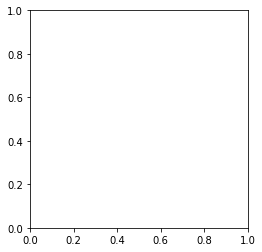

In [24]:
# Convert radiance to Top-of-Atmosphere reflectance
REFLECTANCE_MULT_BAND_2 = 2.0000E-05
REFLECTANCE_ADD_BAND_2 = -0.100000
Mp = REFLECTANCE_MULT_BAND_2
Ap= REFLECTANCE_ADD_BAND_2
TOA_stage_1 = Mp*band2Arr + Ap
plt.imshow(TOA_stage_1)
plt.colorbar()

In [ ]:
# True TOA reflectance
SUN_ELEVATION = 57.43116201
SE = SUN_ELEVATION
TOA_true = TOA_stage_1/ np.cos(np.deg2rad(SE))
plt.imshow(TOA_true)
plt.colorbar()

In [ ]:
xmin = np.nanmin(TOA_true)
xmax = np.nanmax(TOA_true)
fig, ax = plt.subplots(figsize =(10,8))
plt.hist(x= TOA_true.flatten(), color ='purple',bins=1000)
ax.set(title="Distribution of TOA reflectance values",
       xlabel = "TOA reflectance values",
       ylabel ="Frequency",
      xlim = (xmin,xmax)
      )
plt.show()

In [ ]:
tree = ET.ElementTree(file='LC08_L1TP_146039_20220911_20220911_02_RT_MTL.xml')
root = tree.getroot()
print(root)

In [ ]:
arr =[]
for child in root:
    for childs in child:
        if (childs.tag == 'RADIANCE_MULT_BAND_2' or childs.tag== 'RADIANCE_ADD_BAND_2'
           or childs.tag =='REFLECTANCE_MULT_BAND_2' or childs.tag=='REFLECTANCE_ADD_BAND_2'
           or childs.tag =='SUN_ELEVATION'):
            x =childs.text
            arr.append(x)
    
     

In [ ]:
y ='RADIANCE_MULT_BAND_' + str(2)
print(y)

In [ ]:
arr[0]

In [11]:
def preprocess_landsat(file : str,bandNo : int):
    rad_mult_const ='RADIANCE_MULT_BAND_' + str(bandNo)
    rad_add_const = 'RADIANCE_ADD_BAND_' + str(bandNo)
    refl_mult_const = 'REFLECTANCE_MULT_BAND_' + str(bandNo)
    refl_add_const = 'REFLECTANCE_ADD_BAND_' + str(bandNo)
    xmlFile = file[:-2]+'MTL.xml'
    tree = ET.ElementTree(file=xmlFile)
    root = tree.getroot()
    const_arr =[]
    for child in root:
        for childs in child:
            if (childs.tag == rad_mult_const or childs.tag== rad_add_const
               or childs.tag ==refl_mult_const or childs.tag== refl_add_const
               or childs.tag =='SUN_ELEVATION'):
                x =childs.text
                const_arr.append(x)
    tifFile = file +'.TIF'
#     Read the tif file
    readFile = gdal.Open(tifFile)
#     convert file to array
    dn = readFile.ReadAsArray().astype('float')
#     mask the array
    dn[dn==0] = np.nan
#      Convert DN to radiance
    ML = float(const_arr[1])
    AL = float(const_arr[2])
    Spectral_radiance = ML*dn + AL
#     Convert radiance to Top-of-Atmosphere reflectance
    Mp = float(const_arr[3])
    Ap = float(const_arr[4])
    SE = float(const_arr[0])
    TOA = (Mp*dn + Ap)/ np.cos(np.deg2rad(SE))
#     Print constanct
    print('Sun elevation of Image :', SE)
    print(rad_mult_const,':',ML)
    print(rad_add_const,':',AL)
    print(refl_mult_const,':',Mp)
    print(refl_add_const,':',Ap)
    print('Preprocess Completed')
    return Spectral_radiance, TOA
    

In [12]:
x , y = preprocess_landsat('LC08_L1TP_146039_20220911_20220911_02_RT_B2',2)
# LC08_L1TP_146039_20220911_20220911_02_RT_MTL
# LC08_L1TP_146039_20220911_20220911_02_RT_MTL.xml

Sun elevation of Image : 57.43116201
RADIANCE_MULT_BAND_2 : 0.012685
RADIANCE_ADD_BAND_2 : -63.42311
REFLECTANCE_MULT_BAND_2 : 2e-05
REFLECTANCE_ADD_BAND_2 : -0.1
Preprocess Completed


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


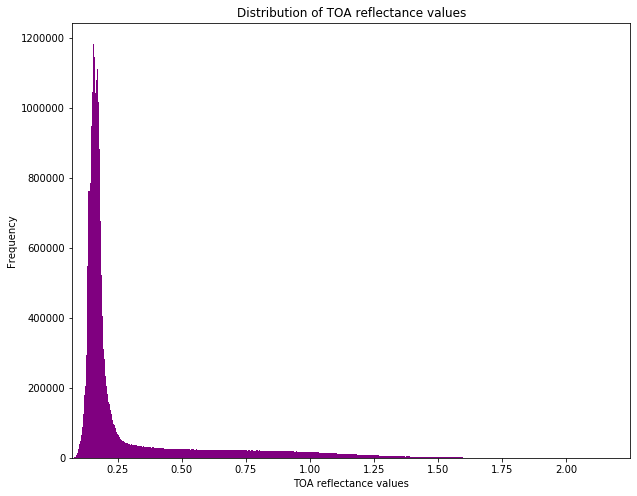

In [9]:
xmin = np.nanmin(y)
xmax = np.nanmax(y)
fig, ax = plt.subplots(figsize =(10,8))
plt.hist(x= y.flatten(), color ='purple',bins=1000)
ax.set(title="Distribution of TOA reflectance values",
       xlabel = "TOA reflectance values",
       ylabel ="Frequency",
      xlim = (xmin,xmax)
      )
plt.show()

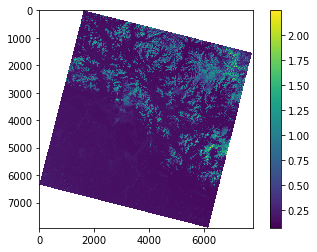

In [10]:
plt.imshow(y)
plt.colorbar()